In [1]:
!pip install tensorflow-datasets==1.2.0
import matplotlib.pyplot as plt
import numpy as np
import re
import os
import tensorflow_datasets as tfds
import tensorflow as tf
tf.random.set_seed(1234)

     |████████████████████████████████| 2.3 MB 3.6 MB/s eta 0:00:01
     |████████████████████████████████| 449 kB 39.9 MB/s eta 0:00:01
  Created wheel for psutil: filename=psutil-5.7.0-cp36-cp36m-linux_x86_64.whl size=279860 sha256=0949a539e98748f03d651fd5e61373647f212749a0b332d428f6a5a648e5f9ec
  Stored in directory: /root/.cache/pip/wheels/a1/d9/f2/b5620c01e9b3e858c6877b1045fda5b115cf7df6490f883382
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=23950 sha256=e3ebcd720521b6c1d40c788b37d23479493af42a2fa7f42fbfe74f22471be968
  Stored in directory: /root/.cache/pip/wheels/59/9a/1d/3f1afbbb5122d0410547bf9eb50955f4a7a98e53a6d8b99bd1
Successfully built psutil promise
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
def preprocess_sentence(sentence):
    sentence = sentence.strip()
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
    sentence = sentence.strip()
    # adding a start and an end token to the sentence
    return sentence


def load_text(path_to_text, min_line_chars=75):
    texts = []
    with open(path_to_text, errors='ignore') as file:
        lines = file.readlines()
    for line in lines:
        if len(line) < min_line_chars or line[0] == '[' or line[0] == '"':
            continue
        if line.lower().startswith(path_to_text.split('.')[0].lower()):
            continue
        texts.extend(preprocess_sentence(line.replace('\n', '')).split())
    return texts


text = load_text('/home/sam/LSD.txt')
print(f'len text {len(text)}\n Sample text: {text[220:242]}')
print(f'\n More Sample text: {text[34:45]}')

len text 1899688
 Sample text: ['and', 'that', 'with', 'our', 'out', 'of', 'town', 'friend', 'coming', 'to', 'hang', 'out', 'on', 'Friday', 'with', 'us', 'that', 'we', 'd', 'probably', 'have', 'a']

 More Sample text: [',', 'but', 'felt', 'extremely', 'cautious', 'about', 'it', '.', 'So', 'when', 'it']


In [3]:
# Build tokenizer using tfds for both questions and answers
tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(text, target_vocab_size=2**13)

# Define start and end token to indicate the start and end of a sentence
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# Vocabulary size plus start and end token
VOCAB_SIZE = tokenizer.vocab_size + 2
print(f'Vocabulary size: {VOCAB_SIZE}')

Vocabulary size: 8268


In [4]:
print(f'Sample text: {text[520:542]}')
print(f'Tokenized sample text: {len(tokenizer.encode("".join(text[520:542])))}, tokens:{tokenizer.encode("".join(text[520:542]))}')

Sample text: ['was', 'so', 'happy', 'and', 'realized', 'how', 'much', 'I', 'enjoyed', 'my', 'life', 'that', 'all', 'of', 'my', 'past', 'eventually', 'became', 'entirely', 'unimportant', 'to', 'me']
Tokenized sample text: 25, tokens:[4, 25, 394, 2, 230, 77, 105, 8083, 874, 6, 95, 9, 24, 5, 6, 5522, 4948, 6332, 218, 1183, 1959, 3333, 5887, 558, 6089]


In [5]:
# Burn in sentence length
BURN_IN = 16
TOKENS_TO_EMIT = 16

def tokenize_sliding_window(inputs, max_sentence_length, step_size=232):
    tokenized_inputs = []

    for i in range(0, len(inputs)-max_sentence_length, step_size):
        # tokenize sentence
        tokens = tokenizer.encode("".join(inputs[i:i+max_sentence_length]))
        sentence1 = START_TOKEN + tokens[:max_sentence_length-2] + END_TOKEN
        tokenized_inputs.append(sentence1)
    
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=max_sentence_length, padding='post')
    return tokenized_inputs

tokenized_text = tokenize_sliding_window(text, BURN_IN+TOKENS_TO_EMIT)
print(f'Number of tokenized samples: {len(tokenized_text)}')

Number of tokenized samples: 8189


In [6]:
print(f'{len(tokenized_text[4])}\n Tokens: {tokenized_text[4]} \nDecoded: {tokenizer.decode(tokenized_text[4, 1:-1]%(VOCAB_SIZE-2))}')

32
 Tokens: [8266 2768 4566 1313 5567  401  106    2    8  134 1395  228 6072 8125
 8056 8083   99   44    1  436  106    2  235 1582 1777   21 2783 1790
 8119   11 1960 8267] 
Decoded: aninterrogationroomanditmademenervous.Ilookedintothelivingroomanditseemedliketheroomhadstretched


In [7]:
print(f'Decoded: {tokenizer.encode(" ")}')

Decoded: [8042]


In [8]:
BATCH_SIZE = 32
BUFFER_SIZE = 20000

# decoder inputs use the previous target as input
# remove START_TOKEN from targets
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': tokenized_text[:, :BURN_IN],
        'dec_inputs': tokenized_text[:, BURN_IN-TOKENS_TO_EMIT:BURN_IN]
    },
    {
        'outputs': tokenized_text[:, -TOKENS_TO_EMIT:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [9]:
print(dataset)

<PrefetchDataset shapes: ({inputs: (None, 16), dec_inputs: (None, 16)}, {outputs: (None, 16)}), types: ({inputs: tf.int32, dec_inputs: tf.int32}, {outputs: tf.int32})>


In [10]:
def scaled_dot_product_attention(query, key, value, mask):
    """Calculate the attention weights. """
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # scale matmul_qk
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # add the mask to zero out padding tokens
    if mask is not None:
        logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k)
    attention_weights = tf.nn.softmax(logits, axis=-1)

    output = tf.matmul(attention_weights, value)

    return output

In [11]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # linear layers
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # split heads
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # scaled dot-product attention
        scaled_attention = scaled_dot_product_attention(
            query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # concatenation of heads
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # final linear layer
        outputs = self.dense(concat_attention)

        return outputs

In [12]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [13]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


In [14]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - \
        tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

In [15]:
print(create_look_ahead_mask(tf.constant([[1, 2, 0, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 0. 1.]
   [0. 0. 1. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


In [16]:
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) /
                            tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
        # apply sin to even index in the array
        sines = tf.math.sin(angle_rads[:, 0::2])
        # apply cos to odd index in the array
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

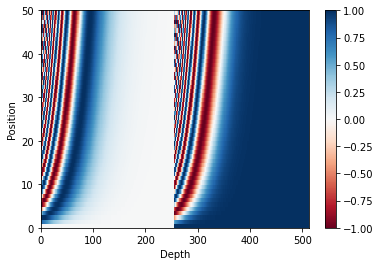

In [17]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [18]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': padding_mask
        })
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(inputs + attention)

    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

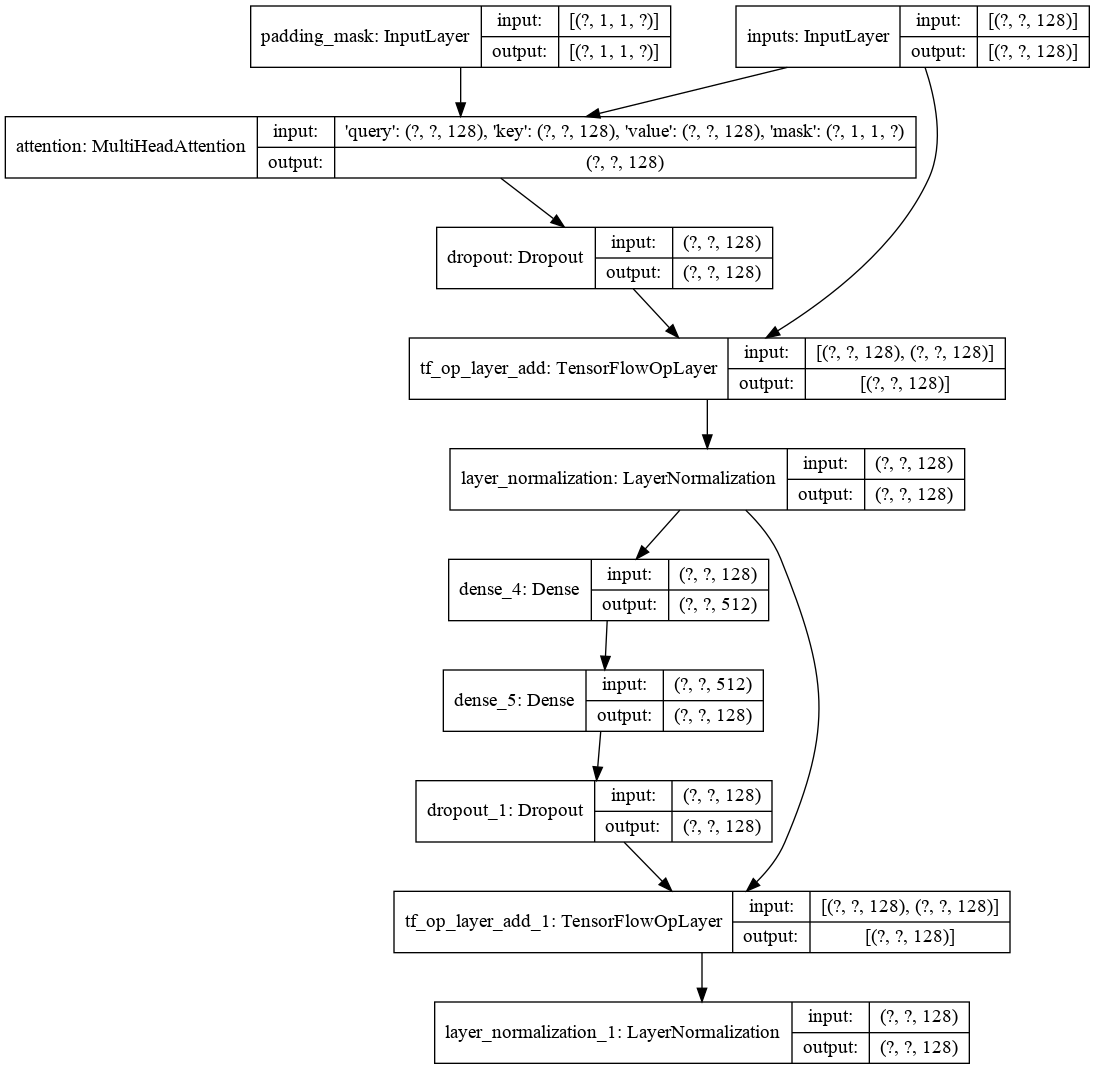

In [19]:
sample_encoder_layer = encoder_layer(
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_encoder_layer")

tf.keras.utils.plot_model(
    sample_encoder_layer, to_file='encoder_layer.png', show_shapes=True)

In [20]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [21]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': look_ahead_mask
        })
    attention1 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention1 + inputs)

    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
            'query': attention1,
            'key': enc_outputs,
            'value': enc_outputs,
            'mask': padding_mask
        })
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention2 + attention1)

    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

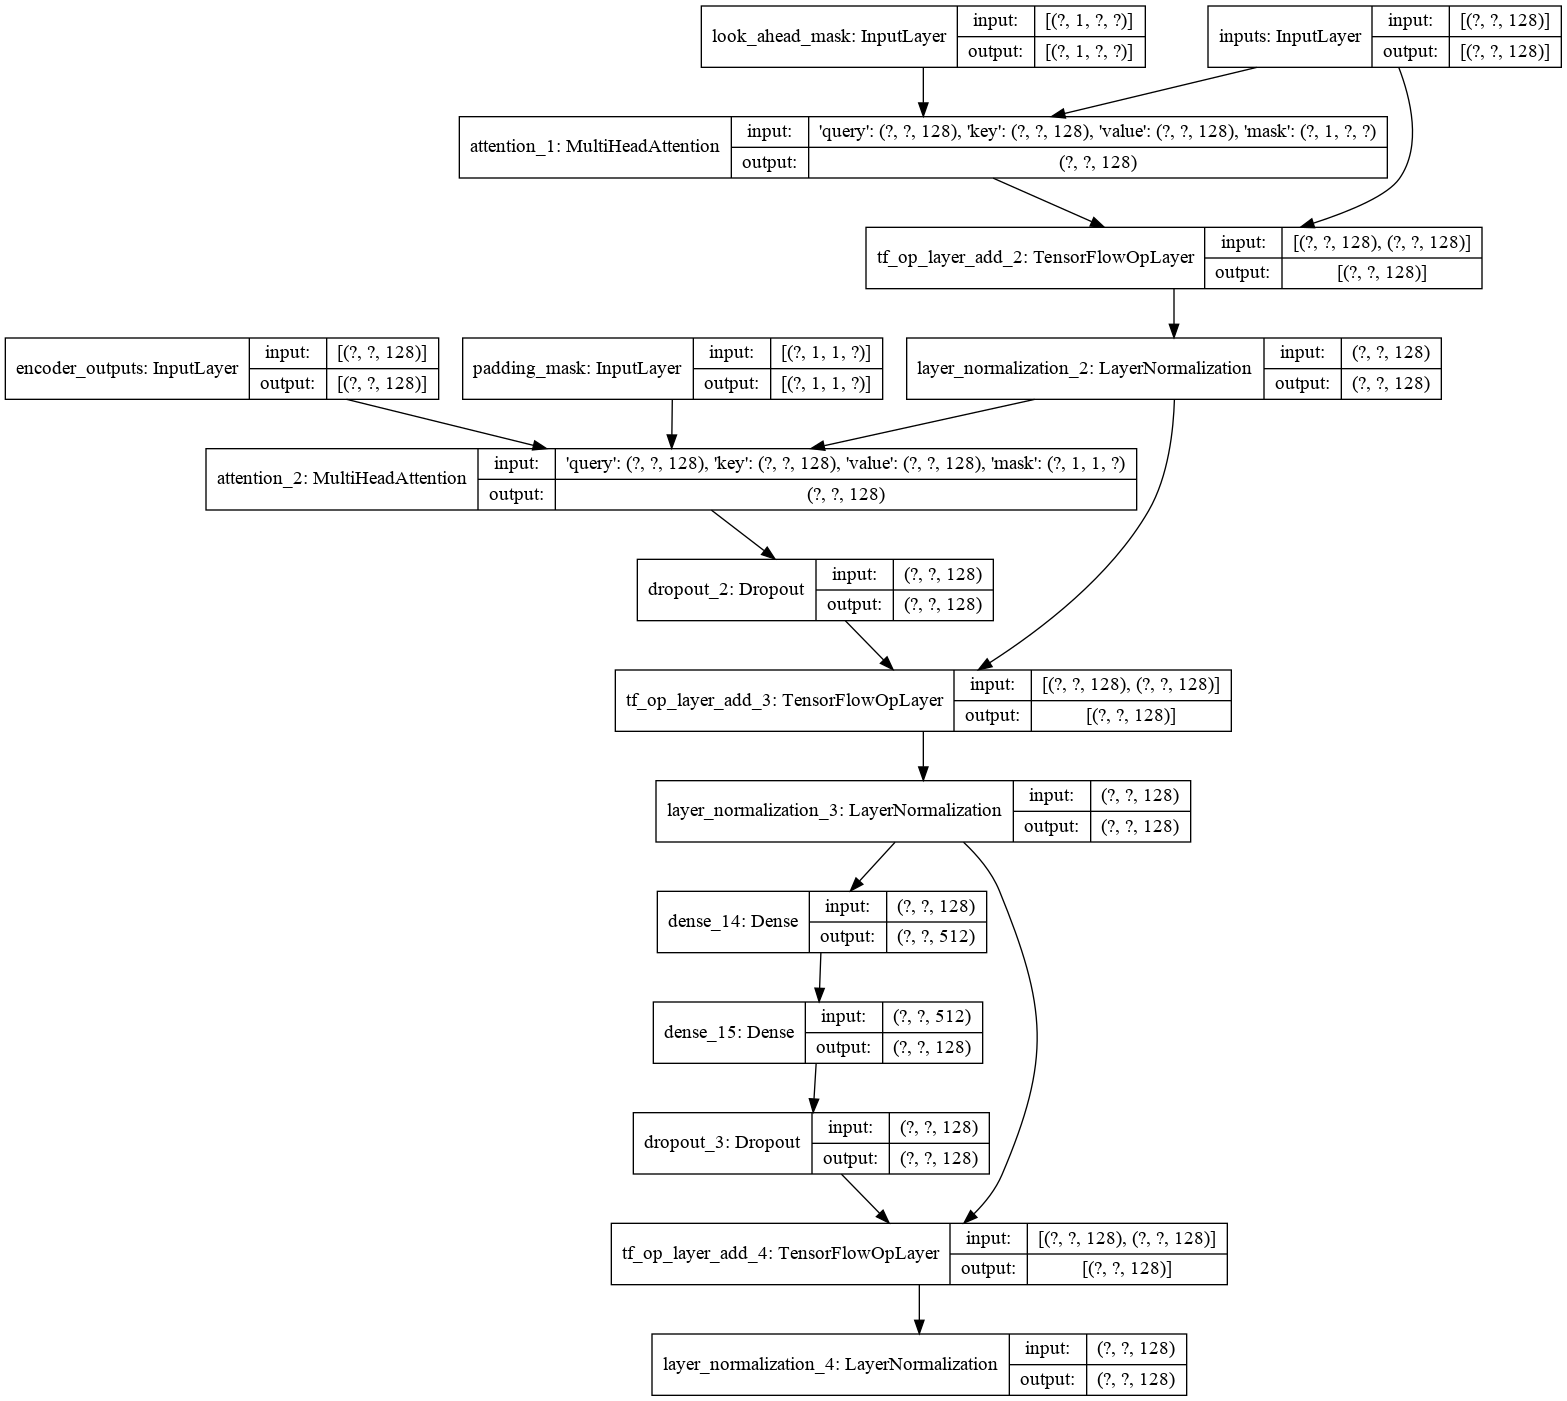

In [22]:
sample_decoder_layer = decoder_layer(
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_decoder_layer")

tf.keras.utils.plot_model(
    sample_decoder_layer, to_file='decoder_layer.png', show_shapes=True)

In [23]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name='look_ahead_mask')
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

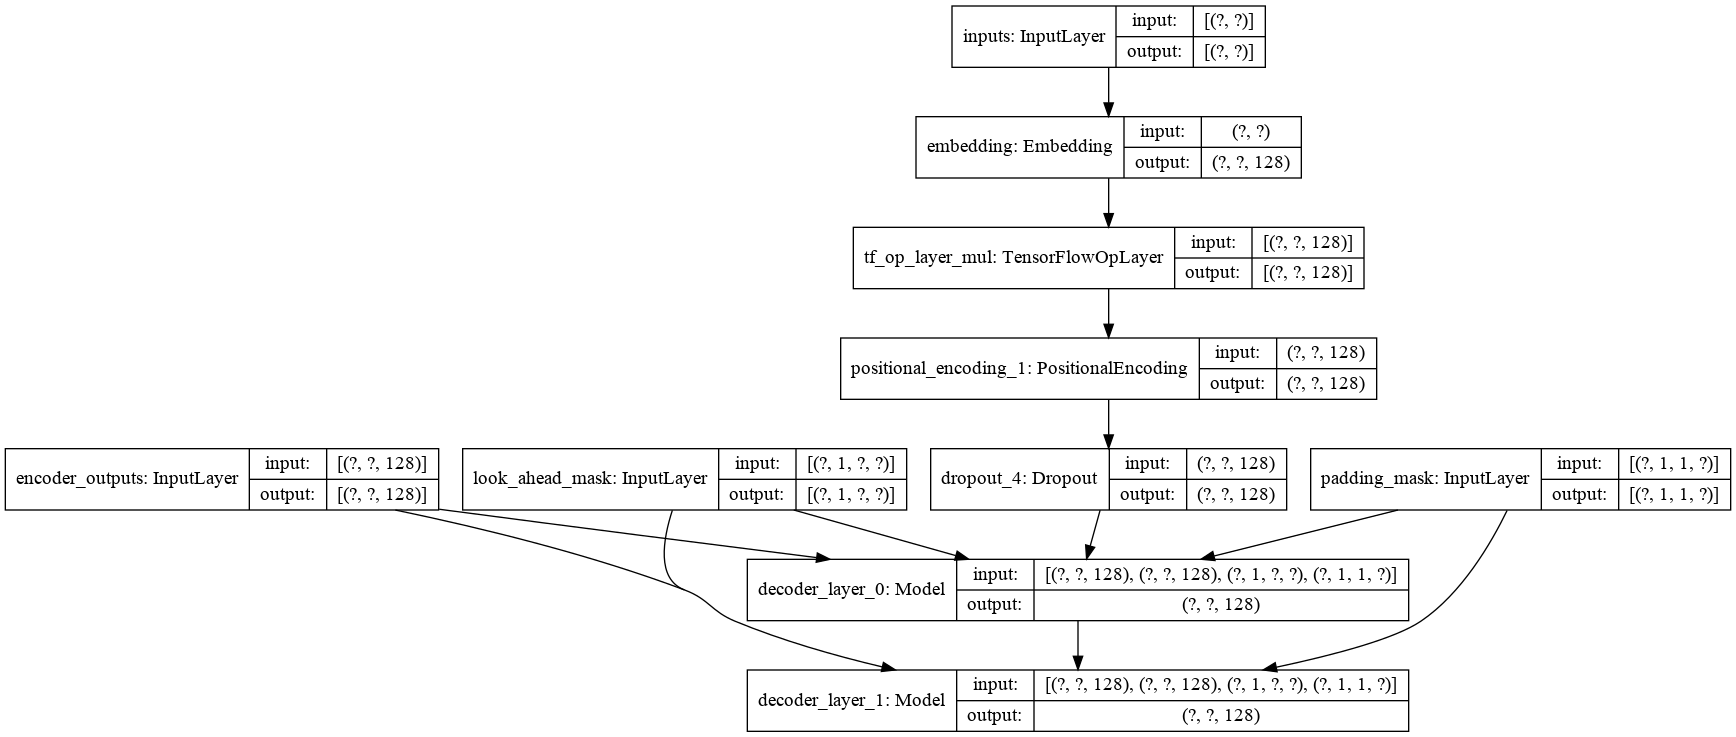

In [24]:
sample_decoder = decoder(
    vocab_size=VOCAB_SIZE,
    num_layers=2,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_decoder")

tf.keras.utils.plot_model(
    sample_decoder, to_file='decoder.png', show_shapes=True)

In [25]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)
    # mask the future tokens for decoder inputs at the 1st attention block
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)
    # mask the encoder outputs for the 2nd attention block
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    outputs = tf.keras.layers.Dense(
        units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

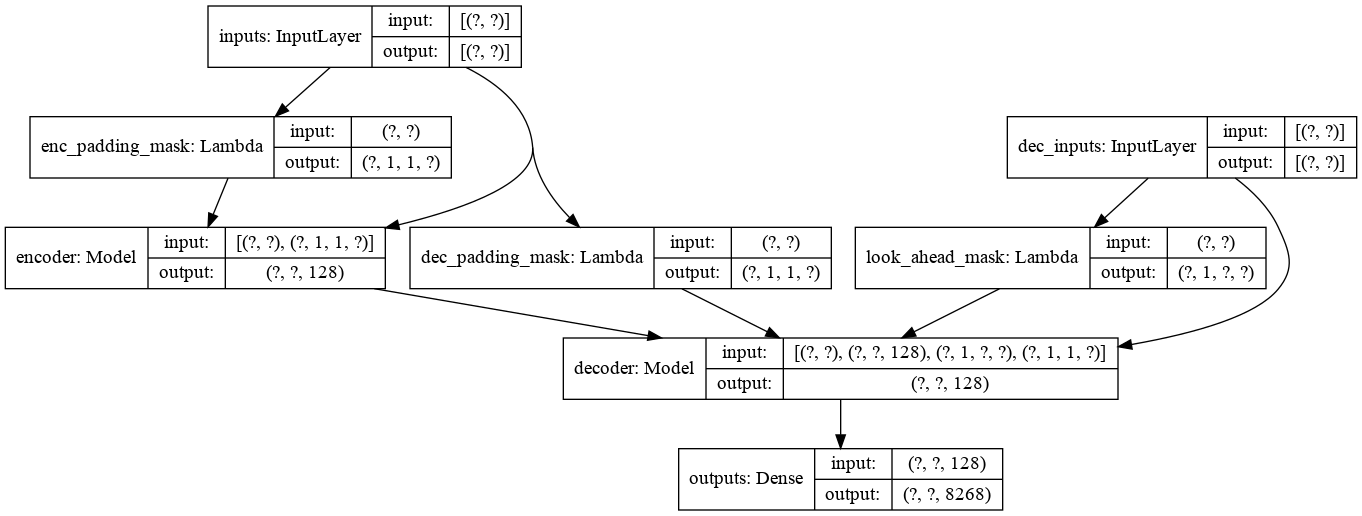

In [26]:
sample_transformer = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=4,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_transformer")

tf.keras.utils.plot_model(
    sample_transformer, to_file='transformer.png', show_shapes=True)

In [27]:
tf.keras.backend.clear_session()

# Hyper-parameters
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

In [28]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, TOKENS_TO_EMIT))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

In [29]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

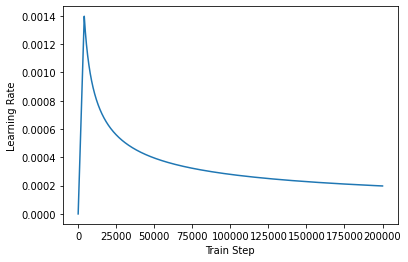

In [30]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [31]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)


def accuracy(y_true, y_pred):
    # ensure labels have shape (batch_size, TOKENS_TO_EMIT)
    y_true = tf.reshape(y_true, shape=(-1, TOKENS_TO_EMIT))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)


model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [32]:
EPOCHS = 140
model.fit(dataset, epochs=EPOCHS)

Train for 256 steps
Epoch 1/140
256/256 [==============================] - 29s 112ms/step - loss: 8.3032 - accuracy: 0.0494
Epoch 2/140
256/256 [==============================] - 20s 77ms/step - loss: 6.7093 - accuracy: 0.1019
Epoch 3/140
256/256 [==============================] - 20s 77ms/step - loss: 6.4875 - accuracy: 0.1062
Epoch 4/140
256/256 [==============================] - 20s 76ms/step - loss: 6.4779 - accuracy: 0.1067
Epoch 5/140
256/256 [==============================] - 20s 78ms/step - loss: 6.4310 - accuracy: 0.1103
Epoch 6/140
256/256 [==============================] - 21s 80ms/step - loss: 6.3152 - accuracy: 0.1151
Epoch 7/140
256/256 [==============================] - 20s 77ms/step - loss: 6.1355 - accuracy: 0.1209
Epoch 8/140
256/256 [==============================] - 19s 76ms/step - loss: 5.9033 - accuracy: 0.1292
Epoch 9/140
256/256 [==============================] - 20s 76ms/step - loss: 5.5971 - accuracy: 0.1419
Epoch 10/140
256/256 [==============================

KeyboardInterrupt: 

In [ ]:
space_id = [tokenizer.encode(" ")]

def evaluate(sentence):
    sentence = preprocess_sentence(sentence)

    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    output = tf.expand_dims(START_TOKEN, 0)

    for i in range(TOKENS_TO_EMIT):
        predictions = model(inputs=[sentence, output], training=False)

        # select the last word from the seq_len dimension
        predictions = predictions[:, -1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        #print(f'{predicted_id.shape}')
        # return the result if the predicted_id is equal to the end token
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # concatenated the predicted_id to the output which is given to the decoder
        # as its input.
        #output = tf.concat([output, space_id, predicted_id], axis=-1)
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0)
def predict(sentence):
    prediction = evaluate(sentence)
    print(f'prediction shape:{prediction.shape} prediction: {prediction}')
    predicted_sentence = '' 
    for i in prediction:
        if i < tokenizer.vocab_size:
            predicted_sentence += tokenizer.decode([i, tokenizer.encode(" ")[0]])
    print(f'Input: {sentence}')
    print(f'Output: {predicted_sentence}')

    return predicted_sentence

In [ ]:
output = predict('I feel a little guilty about submitting this since')

In [ ]:
# afouruoufforafanagedsand,,,,,,,,,fffffaffafbeasandsandei
output = predict("The music began and")

In [ ]:
# feed the model with its previous output
sentence = 'What kind of raving trance'
for _ in range(15):
    sentence = predict(sentence)
    print('')